In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.is_available()

True

In [61]:
opt = {
    "dimension": 2,
    "num_atoms":100,
    "hidden_size": 100,
    "simulate": 1000
}

In [53]:
# Force Field
class ForceField(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForceField, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

In [54]:
# Atom Coordinates
class AtomCoordinates(nn.Module):
    def __init__(self, num_atoms, scale=1):
        super(AtomCoordinates, self).__init__()
        self.coordinates = nn.Parameter(torch.randn(num_atoms, opt["dimension"])*scale)

    def forward(self):
        return self.coordinates

In [55]:
# Data
def lennard_jones_potential(r, eps=1e-1):
#     return 1.5**12 / (r+eps)**12 - 1.5**6 / (r+eps)**6
    return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates, coordinates)
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field, num_iterations=100, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates).view(-1, 1)))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 1000 == -1:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [64]:
# Train
def train(force_field, atom_coordinates, num_iterations=1000):
    atom_optimizer = optim.Adam(atom_coordinates.parameters(), lr=0.1)
    force_optimizer = optim.Adam(force_field.parameters(), lr=0.01)
    
#     best_loss = float('inf')
    for iteration in range(num_iterations): 
        # MD Simulation
        if iteration % opt["simulate"] == 0:
            atom_stable = AtomCoordinates(opt["num_atoms"]).to(device)
            stable_conformations = simulate_stable_conformations(atom_stable(), lennard_jones_potential, num_iterations=opt["simulate"])
#         if (iteration+opt["simulate"]//2) % opt["simulate"] == 0:
#             atom_coordinates = AtomCoordinates(opt["num_atoms"])
#             atom_optimizer = optim.Adam(atom_coordinates.parameters(), lr=0.01)
            
        # Atom Coordinates
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates.coordinates).view(-1, 1)))
        atom_optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates.parameters(), 0.1)
        atom_optimizer.step()

        # Force Field
        tempor_conformations = atom_coordinates.coordinates.clone().detach()
        temp_energy = torch.sum(force_field(distances_matrix(tempor_conformations).view(-1, 1)))        
        true_energy = torch.sum(force_field(distances_matrix(stable_conformations).view(-1, 1)))
        energy_difference = true_energy - temp_energy
        loss_energy = energy_difference + torch.abs(torch.mean(force_field(torch.arange(0.5, 50., 0.1).to(device).view(-1, 1))))
        force_optimizer.zero_grad()
        loss_energy.backward()
        torch.nn.utils.clip_grad_norm_(force_field.parameters(), 0.1)
        force_optimizer.step()  
        
#         if loss_energy < best_loss:
#             torch.save(atom_coordinates.state_dict(), 'best_atom.pth')
#             torch.save(force_field.state_dict(), 'best_force.pth')
#             best_loss = loss_energy

        # Print progress
        if iteration % 1000 == 0:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()},  Energy Difference: {energy_difference.item()}")

In [65]:
atom_coordinates = AtomCoordinates(opt["num_atoms"]).to(device)
force_field = ForceField(1, opt["hidden_size"], 1).to(device)
train(force_field, atom_coordinates, 30000)

Iteration 0, Potential Energy: 1509.04736328125,  Energy Difference: 437.628173828125
Iteration 1000, Potential Energy: -160665.0,  Energy Difference: 272.265625
Iteration 2000, Potential Energy: -142767.703125,  Energy Difference: -339.328125
Iteration 3000, Potential Energy: -130673.3359375,  Energy Difference: 1054.421875
Iteration 4000, Potential Energy: -167617.4375,  Energy Difference: -901.359375
Iteration 5000, Potential Energy: -101506.5078125,  Energy Difference: 195.375
Iteration 6000, Potential Energy: -148159.375,  Energy Difference: -914.90625
Iteration 7000, Potential Energy: -104780.5546875,  Energy Difference: -538.5078125
Iteration 8000, Potential Energy: 3372.6572265625,  Energy Difference: 8.221435546875
Iteration 9000, Potential Energy: -3197.308837890625,  Energy Difference: 3.86279296875
Iteration 10000, Potential Energy: -4731.75341796875,  Energy Difference: -0.64990234375
Iteration 11000, Potential Energy: -51.2100944519043,  Energy Difference: 0.1304550170898

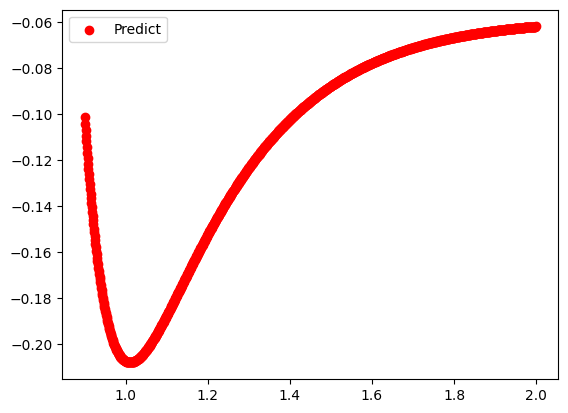

In [66]:
# atom_coordinates.load_state_dict(torch.load('best_atom.pth'))
# force_field.load_state_dict(torch.load('best_force.pth'))

x_data = torch.arange(0.9, 2.0, 0.001).to(device)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

# plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
plt.scatter(x_data.cpu().numpy(), y_pred.cpu().numpy(), label='Predict', color='red')
plt.legend()
plt.show()

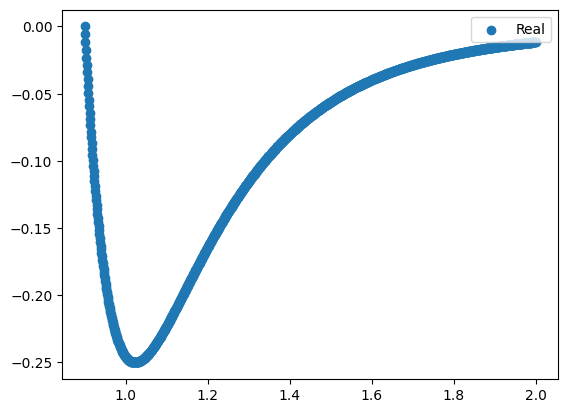

In [67]:
x_data = torch.arange(0.9, 2.0, 0.001).to(device)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

plt.scatter(x_data.cpu().numpy(), y_real.cpu().numpy(), label='Real')
# plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

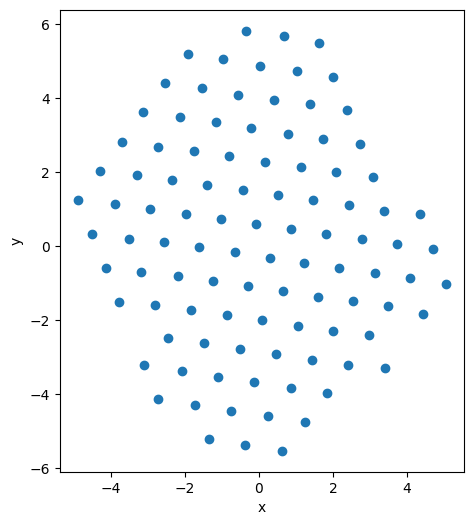

In [68]:
coordinates = atom_coordinates.coordinates.cpu().detach().numpy()
plt.figure(figsize=(6, 6)) 
plt.scatter(coordinates[:,0], coordinates[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

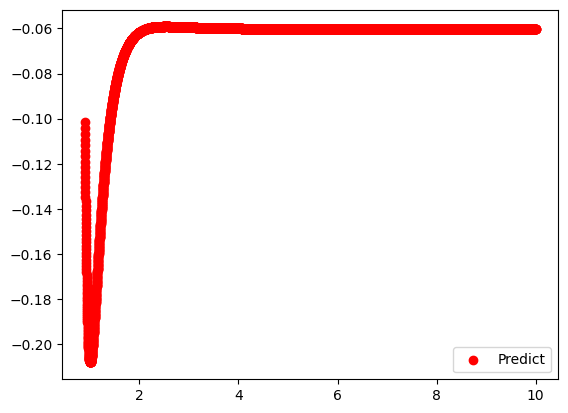

In [73]:
# atom_coordinates.load_state_dict(torch.load('best_atom.pth'))
# force_field.load_state_dict(torch.load('best_force.pth'))

x_data = torch.arange(0.9, 10.0, 0.001).to(device)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

# plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
plt.scatter(x_data.cpu().numpy(), y_pred.cpu().numpy(), label='Predict', color='red')
plt.legend()
plt.show()

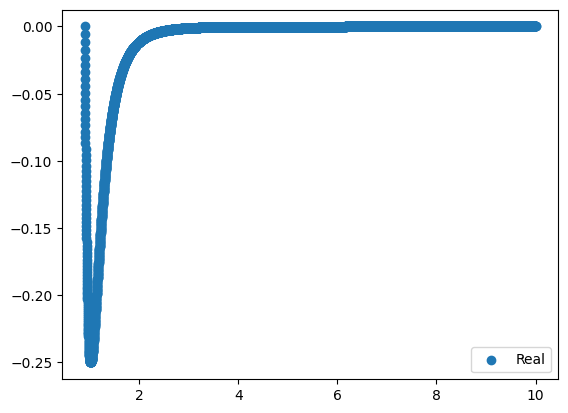

In [74]:
x_data = torch.arange(0.9, 10.0, 0.001).to(device)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

plt.scatter(x_data.cpu().numpy(), y_real.cpu().numpy(), label='Real')
# plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

In [ ]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1.5**12 / (r+eps)**12 - 1.5**6 / (r+eps)**6
#     return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates, coordinates)
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field, num_iterations=100, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates).view(-1, 1)))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 1000 == -1:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [ ]:
x_data = torch.arange(0.9, 5.0, 0.001)
y_real = lennard_jones_potential(x_data)
y_pred = force_field(x_data.view(-1, 1)).detach()

plt.scatter(x_data.numpy(), y_real.numpy(), label='Real')
# plt.scatter(x_data.numpy(), y_pred.numpy(), label='Predict', color='red')
plt.legend()
plt.show()

In [31]:
# Data
def lennard_jones_potential(r, eps=1e-1):
#     return 1.5**12 / (r+eps)**12 - 1.5**6 / (r+eps)**6
    return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates, coordinates)
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field, num_iterations=100, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates).view(-1, 1)))

        optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 1000 == -1:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [32]:
stable_coordinates = AtomCoordinates(opt["num_atoms"])
stable_conformations = simulate_stable_conformations(stable_coordinates(), lennard_jones_potential, num_iterations=5000)
coordinates = stable_conformations.data.numpy()

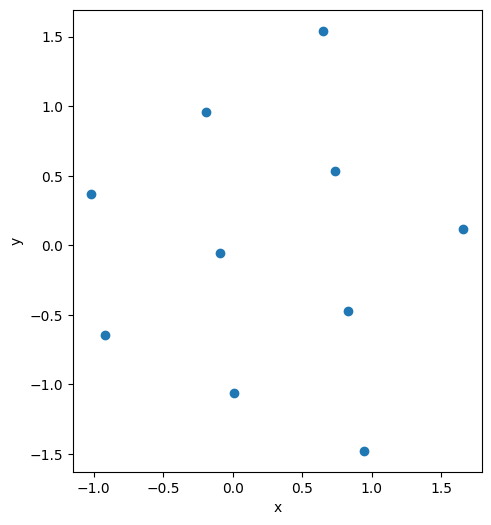

In [37]:
plt.figure(figsize=(6, 6)) 
plt.scatter(coordinates[:,0], coordinates[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [22]:
stable_coordinates()

Parameter containing:
tensor([[ 0.4397,  0.1124],
        [ 0.6408,  0.4412],
        [ 0.2055, -0.4503],
        [-0.5731, -0.5554],
        [ 0.5943,  1.5419],
        [ 0.5073, -0.5910],
        [-1.3253,  0.1886],
        [-0.0691, -0.4949],
        [-1.4959, -0.1938],
        [ 0.4455,  1.3253]], requires_grad=True)

In [19]:
stable_coordinates = AtomCoordinates(10)
stable_conformations = simulate_stable_conformations(stable_coordinates(), force_field, num_iterations=1000)
coordinates = stable_conformations.data.numpy()

NameError: name 'force_field' is not defined

In [ ]:
plt.scatter(range(len(coordinates)), np.sort(coordinates))
plt.xlabel('Atom Index')
plt.ylabel('Atom Coordinates')
plt.title('1D Scatter Plot of Atom Coordinates')
plt.show()

In [ ]:
# Data
def lennard_jones_potential(r, eps=1e-1):
    return 1 / (r+eps)**12 - 1 / (r+eps)**6

def distances_matrix(coordinates):
    matrix_size = coordinates.shape[0]
    distances = torch.cdist(coordinates.view(-1, 1), coordinates.view(-1, 1))
    indices = torch.triu_indices(matrix_size, matrix_size, offset=1)
    distances = distances[indices[0], indices[1]]
    return distances

def simulate_stable_conformations(atom_coordinates, force_field=lennard_jones_potential, num_iterations=1000, lr=0.01):
    optimizer = optim.Adam([atom_coordinates], lr=lr)
    
    for iteration in range(num_iterations):
        potential_energy = torch.sum(force_field(distances_matrix(atom_coordinates)))

        optimizer.zero_grad()
        potential_energy.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(atom_coordinates, 1)
        optimizer.step()

        if iteration % 500 == 0:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()}")

    return atom_coordinates

In [ ]:
atom_coordinates()

In [ ]:
stable_conformations

In [28]:
# a = torch.tensor([1., 4., 7.])
# b = torch.tensor([2., 3., 4.])
# dis = torch.cdist(a.view(-1, 1), b.view(-1, 1))
a = torch.tensor([[1., 0.], [4., 0.], [7., 0.]])
b = torch.tensor([[2., 0.], [3., 0.], [4., 4.]])
dis = torch.cdist(a, b)
print(dis)

tensor([[1., 2., 5.],
        [2., 1., 4.],
        [5., 4., 5.]])


In [ ]:
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = torch.tensor([[10, 10, 10], [10, 10, 10], [10, 10, 10]])
torch.tril(a, diagonal=-1) + torch.triu(b, diagonal=0)

In [ ]:
a.view(-1)

In [ ]:
# Create a square matrix
matrix_size = 5
matrix = torch.randn(matrix_size, matrix_size)

# Get the upper triangle indices
upper_triangle_indices = torch.triu_indices(matrix_size, matrix_size, offset=1)

# Slice the upper triangle of the matrix
upper_triangle_values = matrix[upper_triangle_indices[0], upper_triangle_indices[1]]

print("Original Matrix:")
print(matrix)

print("\nUpper Triangle Values:")
print(upper_triangle_values)

In [ ]:
# Train
def train(force_field, atom_coordinates, num_iterations=1000):
    away_coordinates = AtomCoordinates(opt["num_atoms"], 10)
    atom_optimizer = optim.Adam([
        {'params': atom_coordinates.parameters()},
        {'params': away_coordinates.parameters()}
    ], lr=0.01)
    force_optimizer = optim.Adam(force_field.parameters(), lr=0.01)
    
    for iteration in range(num_iterations): 
        # MD Simulation
        if iteration % opt["simulate"] == 0:
            atom_stable = AtomCoordinates(opt["num_atoms"])
            stable_conformations = simulate_stable_conformations(atom_stable(), lennard_jones_potential, num_iterations=opt["simulate"])
        if (iteration+opt["simulate"]//2) % opt["simulate"] == 0:
            away_coordinates = AtomCoordinates(opt["num_atoms"], 10)
            
        best_loss = float('inf')
        # Atom Coordinates
        potential_energy_atom = torch.sum(force_field(distances_matrix(atom_coordinates.coordinates).view(-1, 1)))
        potential_energy_away = torch.sum(force_field(distances_matrix(away_coordinates.coordinates).view(-1, 1)))
        potential_energy = potential_energy_atom + potential_energy_away
        atom_optimizer.zero_grad()
        potential_energy.backward()
        torch.nn.utils.clip_grad_norm_(atom_coordinates.parameters(), 0.1)
        torch.nn.utils.clip_grad_norm_(away_coordinates.parameters(), 0.1)
        atom_optimizer.step()

        # Force Field
        tempor_conformations_atom = atom_coordinates.coordinates.clone().detach()
        tempor_conformations_away = away_coordinates.coordinates.clone().detach()
        temp_energy_atom = torch.sum(force_field(distances_matrix(tempor_conformations_atom).view(-1, 1)))        
        temp_energy_away = torch.sum(force_field(distances_matrix(tempor_conformations_away).view(-1, 1)))        
        true_energy = torch.sum(force_field(distances_matrix(stable_conformations).view(-1, 1)))
        energy_difference = true_energy - temp_energy_atom  + true_energy - temp_energy_away
        loss_energy = energy_difference + torch.abs(torch.mean(force_field(torch.arange(0.5, 50., 0.1).view(-1, 1))))
        force_optimizer.zero_grad()
        loss_energy.backward()
        torch.nn.utils.clip_grad_norm_(force_field.parameters(), 0.1)
        force_optimizer.step()  
        
        if loss_energy < best_loss:
            torch.save(atom_coordinates.state_dict(), 'best_atom.pth')
            torch.save(force_field.state_dict(), 'best_force.pth')
            best_loss = loss_energy

        # Print progress
        if iteration % 1000 == 0:
            print(f"Iteration {iteration}, Potential Energy: {potential_energy.item()},  Energy Difference: {energy_difference.item()}")